# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

RANDOM = 12345
state = np.random.RandomState(RANDOM) 

## Загрузка и подготовка данных

In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
df_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [7]:
df_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [8]:
df_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


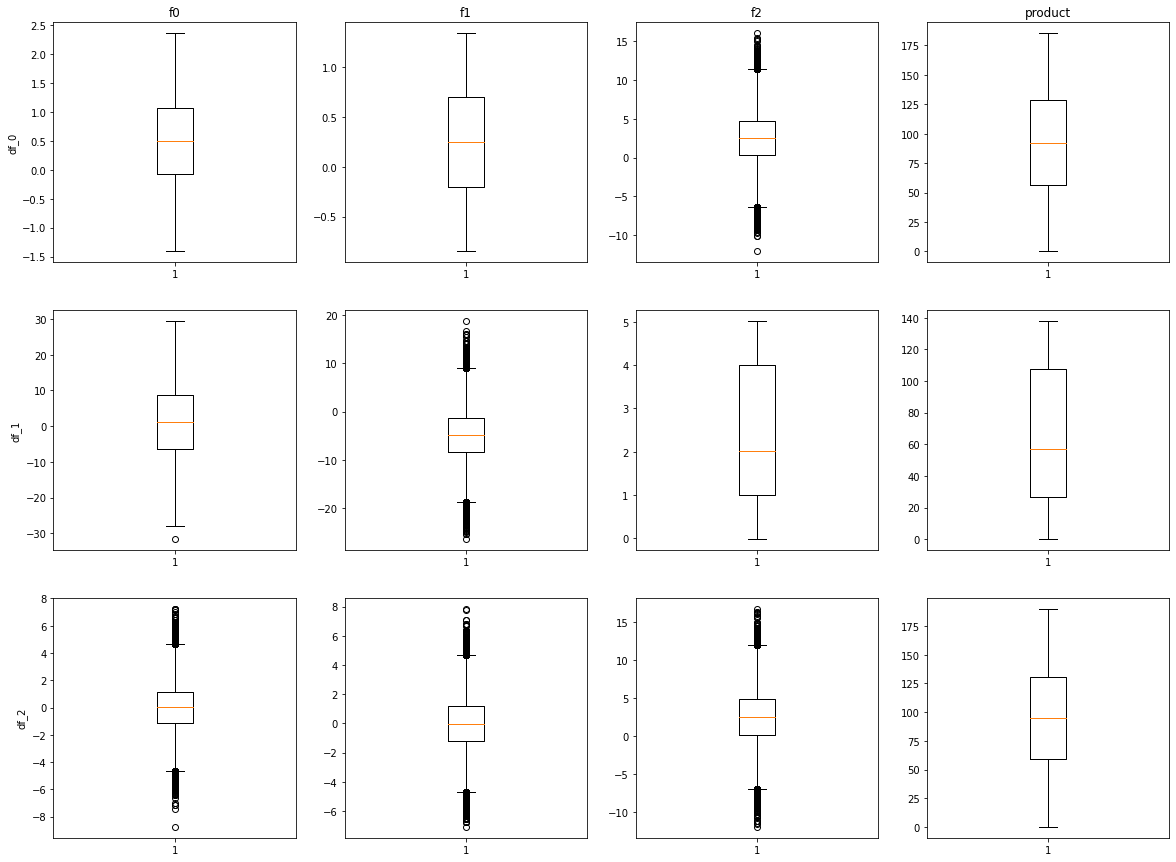

In [9]:
fig,ax = plt.subplots(3,4,figsize = (20,15))

all_frames = ["df_0","df_1","df_2"]
num_columns = df_0.columns[1:]
num_columns_with_columns = zip(df_0.columns[1:],range(4))
all_frames_with_rows = zip([df_0,df_1,df_2],range(3))

for column in list(itertools.product(all_frames_with_rows,num_columns_with_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]])
    
for row in range(3):
    ax[row][0].set_ylabel(all_frames[row])
    
for column in range(4):
    ax[0][column].set_title(num_columns[column])

В данных видны вбросы, поэтому удалим их, а именно в <br>df_0 : f2<br>df_1 : f1<br>df_2 : f1, f2, f3

In [10]:
def del_noise(df, column):
    qu75 = np.array(df[column].quantile(0.75))
    qu25 = np.array(df[column].quantile(0.25))
    
    top = qu75 + 1.5 * (qu75 - qu25)
    botton = qu25 - 1.5 * (qu75 - qu25)
    
    index_noise = []
    
    for i in range(len(df[column])):
        if df[column][i] >= top or df[column][i] <= botton:
            index_noise.append(i)
            
    return index_noise

In [11]:
list_index_noise = []
res_set = set()
for df in [df_0, df_1, df_2]:
    for column in ['f0', 'f1', 'f2']:
        res_set = res_set.union(set(del_noise(df, column)))
    res = list(res_set)
    res.sort()
    list_index_noise.append(res)

In [12]:
print('Доля строк для удаления в df_0 :', len(list_index_noise[0]) / df_0.shape[0] * 100)
print('Доля строк для удаления в df_1 :', len(list_index_noise[1]) / df_1.shape[0] * 100)
print('Доля строк для удаления в df_2 :', len(list_index_noise[2]) / df_2.shape[0] * 100)

Доля строк для удаления в df_0 : 0.506
Доля строк для удаления в df_1 : 1.141
Доля строк для удаления в df_2 : 3.118


Строки с вбросами можно смело уюрать, потому что они составлют малую часть от всех данных, меньше 4 процентов

In [13]:
for df, indexes in zip([df_0, df_1, df_2], list_index_noise):
    df.drop(indexes, axis=0, inplace=True)
    df = df.reset_index(drop=True)

Данные очищенны от вбросов

## Обучение и проверка модели

In [14]:
array_name = [0, 1, 2]
array_frame = [df_0, df_1, df_2]

data_dict = {"pipelines":{},"scores":{},"valid":{}}

for frame, name in zip(array_frame,array_name):
    
    features = frame.drop(["id","product"], axis = 1)
    target = frame["product"]
    
    new_pipeline = make_pipeline(StandardScaler(),LinearRegression())
    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features,
        target,
        test_size = 0.25,
        random_state = RANDOM
    )
    
    data_dict['valid'][name] = (features_valid,target_valid)
    new_pipeline.fit(features_train,target_train)
    
    data_dict['pipelines'][name] = new_pipeline
    
    data_dict['scores'][name] = mean_squared_error(
        target_valid,
        new_pipeline.predict(features_valid)
    )**0.5

In [15]:
best_model_list = [data_dict['pipelines'][k] for k in range(3)]
pred_list = [best_model_list[i].predict(data_dict['valid'][i][0]) for i in range(3)]
true_list = [data_dict['valid'][i][1] for i in range(3)]
rmse_list = [mean_squared_error(data_dict['valid'][i][1], pred_list[i])**0.5 for i in range(3)]

for i in range(3):
    print(f"Среднее df_{i} : {pred_list[i].mean()}")
    print(f"RMSE модели df_{i} : {rmse_list[i]}")
    print()

Среднее df_0 : 92.72476770114889
RMSE модели df_0 : 37.922930890531454

Среднее df_1 : 68.61540950379367
RMSE модели df_1 : 0.8897282958464059

Среднее df_2 : 95.13406669624419
RMSE модели df_2 : 39.80366055241555



df_0 : Среднее находится на втором месте, ошибка также на втором<br>
df_1 : Среднее находится на последнем месте, в то время как ошибка практически нулевая<br>
df_2 : Среднее накходтся на первом месте, как и ошибка

## Подготовка к расчёту прибыли

In [16]:
max_points = 500
points = 200
price = 450000
budget = 10 ** 10

In [17]:
botton_stock = budget / points / price
print(botton_stock)

111.11111111111111


Для того, чтобы месторождение было неубыточным, достаточно, чтобы оно содержало не меньше 111 единиц

In [18]:
for i in range(len(array_frame)):
    print(f"В df_{i} процент безубыточных скважин : {round((array_frame[i]['product'] >= 111.10).sum() / array_frame[i].shape[0] * 100, 2)}%")

В df_0 процент безубыточных скважин : 36.55%
В df_1 процент безубыточных скважин : 16.52%
В df_2 процент безубыточных скважин : 37.99%


Как и ожидалось, третий регион может оказаться самым прибыльным, потом с небольшим отставанием первый, и меньше почти в два споловиной раза идёт второй регион

In [19]:
def income(predictions, true_target):
    predictions_sort = pd.Series(predictions).sort_values(ascending=False)[:points]
    true_target_sort = true_target.reset_index(drop=True)[predictions_sort.index]
    return true_target_sort.sum() * price - budget

## Расчёт прибыли и рисков 

In [20]:
for i in range(3):
    print(f"Прибыль с 200 лучших скважин в df_{i} : {round(income(pred_list[i], true_list[i]), 2)}")

Прибыль с 200 лучших скважин в df_0 : 3346905536.45
Прибыль с 200 лучших скважин в df_1 : 2415086696.68
Прибыль с 200 лучших скважин в df_2 : 2440342581.83


In [21]:
def confidense_interval(true_target, predictions):
    samples = []
    
    for _ in range(1000):
        sample = pd.Series(predictions).sample(n=max_points, replace=True, random_state=state)
        samples.append(income(sample, true_target))
    samples = pd.Series(samples)
    lower = samples.quantile(0.25)
    upper = samples.quantile(0.75)
    return round(lower, 2), round(upper, 2)

In [22]:
def risk_mean(true_target, predictions):
    samples = []
    
    for _ in range(1000):
        sample = pd.Series(predictions).sample(n=max_points, replace=True, random_state=state)
        samples.append(income(sample, true_target))
    samples = pd.Series(samples)
    return (samples < 0).sum() / len(samples) * 100, samples.mean()

In [23]:
for i in range(3):
    risk, mean = risk_mean(true_list[i], pred_list[i])
    low, up = confidense_interval(true_list[i], pred_list[i])
    print(f"Средняя прибыль для df_{i} : {mean}")
    print(f"Риск для df_{i} : {round(risk, 2)}%")
    print(f"Доверительный интервал для df_{i} : ({low}, {up})")
    print()

Средняя прибыль для df_0 : 365761564.95754075
Риск для df_0 : 9.1%
Доверительный интервал для df_0 : (182698011.18, 560671518.23)

Средняя прибыль для df_1 : 427584017.13318336
Риск для df_1 : 1.6%
Доверительный интервал для df_1 : (282923066.18, 559230274.99)

Средняя прибыль для df_2 : 327912655.15026456
Риск для df_2 : 10.8%
Доверительный интервал для df_2 : (137736161.04, 486542103.94)



## Вывод

В качестве заключения работы, лучше всех себя показал себя второй регион<br>
Он имеет минимальный риск, равный 1.8%, что делает его единственным претендентом, согласно условию проекта.<br>
Приблизительная прибыль в этом регионе составляет 433663366, а истинная прибыль с вероятностью 95% лежит в интервале (277216231.49, 582042063.8)

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован